This notebook explores using `RDKit` to find matching 2D structures in organic molecules, using SMARTS queries.  It uses RDKit's very nice structure renderer to show matches.

In [1]:
# import and setup
from rdkit import rdBase
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# use IPythonConsole for pretty drawings
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True

# Defining and viewing some example molecules

In [2]:
# define a few molecules
naphthalene = Chem.MolFromSmiles('c12ccccc1cccc2')
benzoxazole = Chem.MolFromSmiles('n1c2ccccc2oc1')
indane = Chem.MolFromSmiles('c1ccc2c(c1)CCC2')
indole = Chem.MolFromSmiles('C12=C(C=CN2)C=CC=C1')
benzene = Chem.MolFromSmiles('c1ccccc1')
quinoline = Chem.MolFromSmiles('n1cccc2ccccc12')

my_molecules = [naphthalene, 
                benzoxazole,
                indane,
                indole,
                benzene,
                quinoline,
               ]

Our test molecules for this notebook will be the arbitrary set of heterocycles and homocycles (and benzene) above.  

It's easy to get a look at the structure of these molecules.

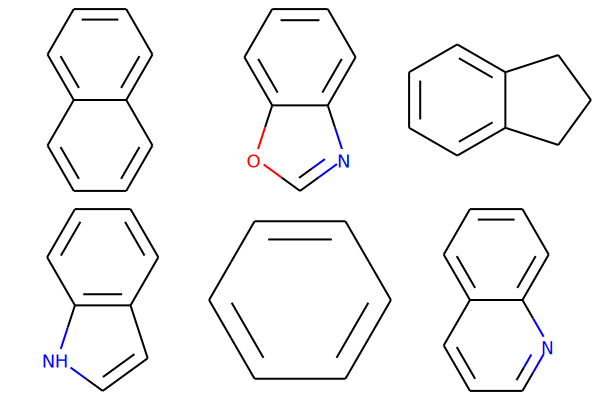

In [12]:
Draw.MolsToGridImage(my_molecules)

For molecules initiated from SMILES, ring properties are instantiated automatically after molecule creation.  Thus, this code that tests whether any atom in each molecule is a member of exactly two SSSR rings works right off the bat.  As expected, all molecules have (at least one atom that is in) two rings, except for the fifth molecule, benzene.

In [3]:
is_in_two_rings = Chem.MolFromSmarts('[R2]')
[mol.HasSubstructMatch(is_in_two_rings) for mol in my_molecules]

[True, True, True, True, False, True]

# Defining structure queries

In [4]:
# define smarts queries for:
#    1. benzene-fused five-membered ring and 
#    2. benzene-fused six-membered ring
benzo_six = Chem.MolFromSmarts('[*r6R1]1[cR2]2[cR1][cR1][cR1][cR1][cR2]2[*r6R1][*r6R1][*r6R1]1')
benzo_five = Chem.MolFromSmarts('[*r5R1]1[cR2]2[cR1][cR1][cR1][cR1][cR2]2[*r5R1][*r5R1]1')
smarts_queries = [benzo_five, benzo_six]

Using SMARTS instead of SMILES to initialize molecules does not result in instantiation of a molecule's RingInfo property.  Thus, until `Chem.GetSSSR()` is invoked on a SMARTS-derived molecule, certain queries will fail.

In [5]:
# our first try fails
try:
    print([mol.HasSubstructMatch(is_in_two_rings) for mol in smarts_queries])
    print('Success!  Your query worked.')
except RuntimeError as err:
    print('ERROR; {0} because RingInfo wasn\'t initialized\n'.format(err))

# initialize rings
[Chem.GetSSSR(mol) for mol in smarts_queries]

# now it works
try:
    print([mol.HasSubstructMatch(is_in_two_rings) for mol in smarts_queries])
    print('Success!  Your query worked.\n')
except RuntimeError as err:
    print('ERROR; {0} because RingInfo wasn\'t initialized'.format(err))

ERROR; Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 37 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2016.03.1
	BOOST: 1_56
 because RingInfo wasn't initialized

[True, True]
Success!  Your query worked.



Now that our query molecules' `RingInfo` is instantiated, it will be possible to compute meaningful 2D sets of coordinates and to use the smarts query molecules for substructure matching.

In [6]:
# compute 2d coords
[AllChem.Compute2DCoords(mol) for mol in smarts_queries]

[0, 0]

In [11]:
# matching the first query
for mol in my_molecules:
    AllChem.GenerateDepictionMatching2DStructure(mol, benzo_five, acceptFailure = True)

Our matching to our first query is done, and now all we have to do is draw the results.

# Showing the hits

The trick here is that the `IPythonConsole` module of `rdkit.Chem.Draw` doesn't seem to pass through the `highlightSubstructs = True` parameter to the appropriate rendering function, even though it does result in setting the `mol.__sssAtoms` property for each molecule.  We can pass this parameter manually.

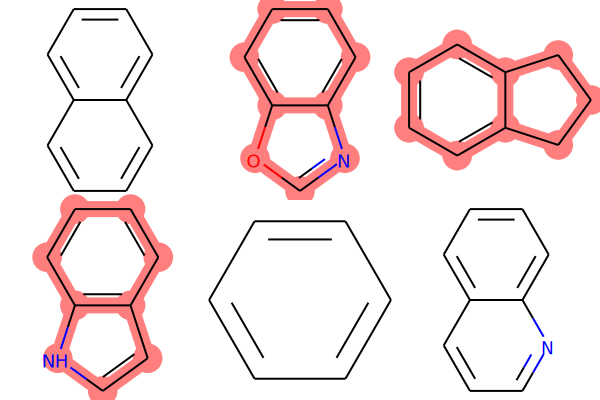

In [8]:
highlight_lists = [mol.__sssAtoms for mol in my_molecules]
Draw.MolsToGridImage(my_molecules, highlightAtomLists = highlight_lists)

The graph above shows that indole, indane, and benzoxazole hit our first query, which tested whether a molecule contained a benzene fused to a five-membered ring.  As expected, benzene isn't highlighted because it doesn't contain two rings, and naphthalene and quinoline aren't highlighted because they contain benzene fused to a _six_-membered ring. 

# Matching to the other query
The other query was to check for benzene fused to six-membered rings.  This should hit naphthalene and quinoline.  

In [9]:
for mol in my_molecules:
    AllChem.GenerateDepictionMatching2DStructure(mol, benzo_six, acceptFailure = True)

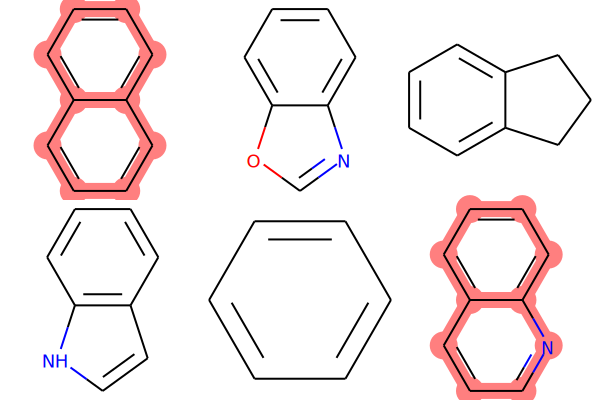

In [10]:
highlight_lists = [mol.__sssAtoms for mol in my_molecules]
Draw.MolsToGridImage(my_molecules, highlightAtomLists = highlight_lists)